Number of sleep observations 11340


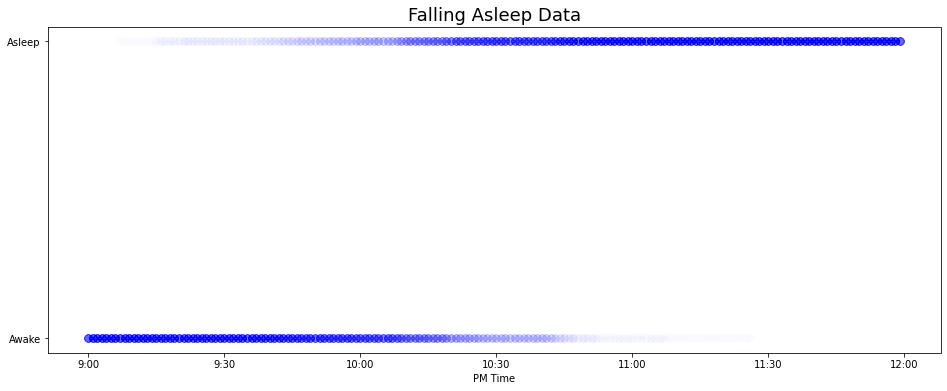

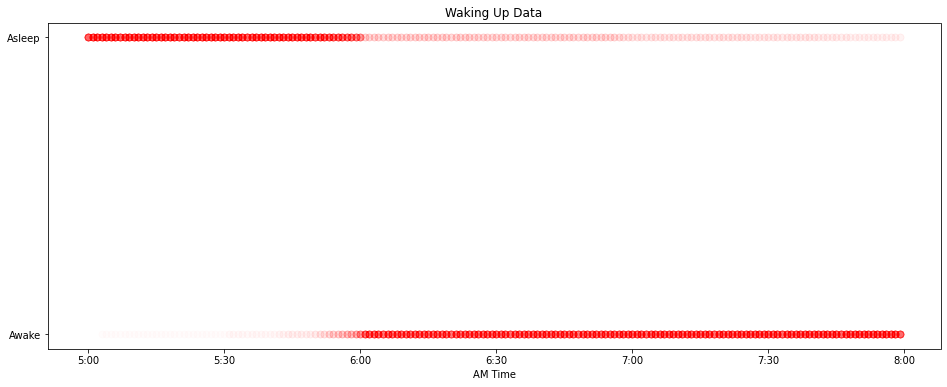

In [1]:
import pandas as pd
import numpy as np
# matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

# Data formatted in different notebook
sleep_data = pd.read_csv('sleep_data.csv')
wake_data = pd.read_csv('wake_data.csv')

# Labels for plotting
sleep_labels = ['9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00']
wake_labels = ['5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00']

print('Number of sleep observations %d' % len(sleep_data))

# Sleep data
plt.figure(figsize=(16, 6))
plt.scatter(sleep_data['time_offset'], sleep_data['indicator'], 
            s= 60, alpha=0.01, facecolor = 'b', edgecolors='b')
plt.yticks([0, 1], ['Awake', 'Asleep']); plt.xlabel('PM Time'); 
plt.title('Falling Asleep Data', size = 18)
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);


# Wake data
plt.figure(figsize=(16, 6))
plt.scatter(wake_data['time_offset'], wake_data['indicator'], 
            s= 50, alpha = 0.01, facecolor='r', edgecolors =  'r');
plt.yticks([0, 1], ['Awake', 'Asleep']); plt.xlabel('AM Time');
plt.title('Waking Up Data')
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

### Logistic Function to Represent Transition

We need to decide on a function to represent the transition from being awake to sleeping. There are a number of acceptable models, and here we will assume this transition can be modeled as a logistic function. A logistic function (also called a sigmoid) is a non-linear function bounded between 0 and 1. As ${t \to -\infty}, {p(s|t) \to 0}$ and, as ${t \to +\infty}, {p(s|t) \to 1}$. The expression for a logistic probability distribution for sleep as a function of time is:

$$p(s|t) = \frac{1}{ 1 + e^{\;\beta t } }$$
The $\beta$ parameter is unknown and be esimated using Markov Chain Monte Carlo sampling. MCMC samples from the prior for each parameter, trying to maximize the probabilty of the parameter given the data.

Several logistic functions with various $\beta$ parameters are shown below:

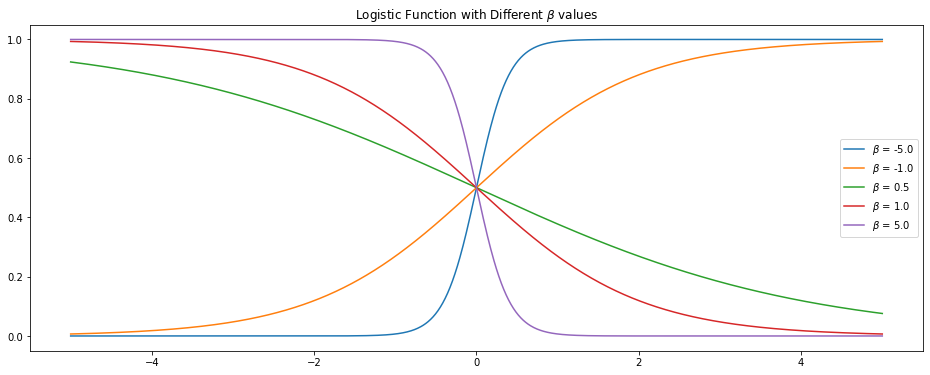

In [2]:
plt.figure(figsize=(16, 6))

# Logistic function with only beta
def logistic(x, beta):
    return 1. / (1. + np.exp(beta * x))

# Plot examples with different betas 
x = np.linspace(-5, 5, 1000)
for beta in [-5, -1, 0.5, 1, 5]:
    plt.plot(x, logistic(x, beta), label = r"$\beta$ = %.1f" % beta)

plt.legend();
plt.title(r'Logistic Function with Different $\beta$ values');

There is one problem with the basic logistic function as shown above: the transition is centered at 0. However, in my sleeping data, the transition is around 10:00 pm for sleeping and 6:00 am for waking. We address this by adding an offset, called a bias, to adjust the location of the logistic function. The logistic function now is:

$$p(t) = \frac{1}{ 1 + e^{\;\beta t + \alpha} }$$
This introduces another unknown parameter, $\alpha$, which we will also find from Markov Chain Monte Carlo.

The logistic function with various $\alpha$ and $\beta$ parameters is shown below.

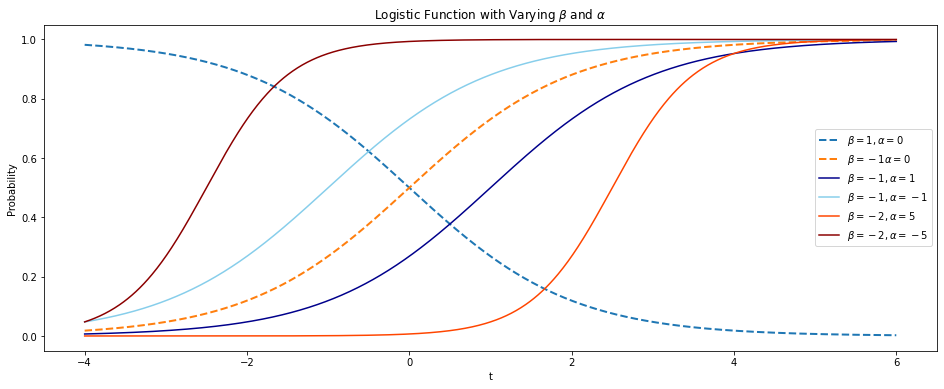

In [3]:
plt.figure(figsize=(16, 6))

# Logistic function with both beta and alpha
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 6, 1000)

plt.plot(x, logistic(x, beta=1), label=r"$\beta = 1, \alpha = 0$", ls="--", lw=2)
plt.plot(x, logistic(x, beta=-1), label=r"$\beta = -1 \alpha = 0$", ls="--", lw=2)

plt.plot(x, logistic(x, -1, 1), 
         label=r"$\beta = -1, \alpha = 1$", color="darkblue")
plt.plot(x, logistic(x, -1, -1),
         label=r"$\beta = -1, \alpha = -1$",color="skyblue")
plt.plot(x, logistic(x, -2, 5), 
         label=r"$\beta = -2, \alpha = 5$", color="orangered")
plt.plot(x, logistic(x, -2, -5), 
         label=r"$\beta = -2, \alpha = -5$", color="darkred")
plt.legend(); plt.ylabel('Probability'); plt.xlabel('t')
plt.title(r'Logistic Function with Varying $\beta$ and $\alpha$');

$\beta$ shifts the direction and steepness of the curve, while $\alpha$ changes the location. We will use MCMC to find the most likely value of these parameters under the data.

#### Prior Distribution for $\beta$ and $\alpha$

We have no evidence to suggest what the prior distributions for the model parameters $\beta$ and $\alpha$ are ahead of time. Therefore, we can model them as if they came from a normal distribution. The normal, or Gaussian, distribution is defined by the mean, $\mu$, and the precision, $\tau$. The precision is the reciprocal of the standard deviation, $\sigma$. The mean defines the location of the distribution and the precision shows the spread. A larger value of $\tau$ indicates the data is less spread out (it is more precise) and hence the variation is smaller. The mean can be either positive or negative, but the precision will always be positive. A normal distribution as defined here is represented as:

$$ f(x | \mu, \tau) = \sqrt{\frac{\tau}{2\pi}} \exp\left( -\frac{\tau}{2} (x - \mu)^2 \right) $$
Probability density functions for three normal distributions are shown below.

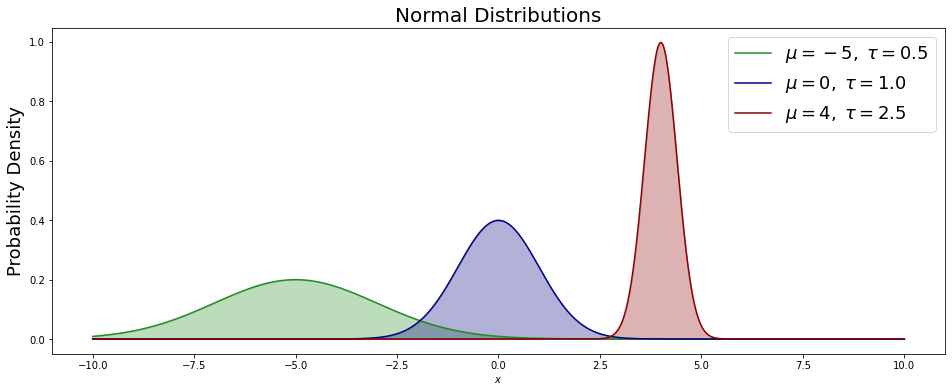

In [4]:
import scipy
from scipy import stats

plt.figure(figsize=(16, 6))

# Set up the plotting parameters
nor = stats.norm 
x= np.linspace(-10, 10, 1000)
mu = (-5, 0, 4)
tau = (0.5, 1, 2.5)
colors = ("forestgreen", "navy", "darkred")

# Plot 3 pdfs for different normal distributions
params = zip(mu, tau, colors)
for param in params:
    y = nor.pdf(x, loc = param[0], scale = 1 / param[1])
    plt.plot(x, y, 
             label="$\mu = %d,\;\\tau = %.1f$" % (param[0], param[1]), 
             color = param[2])
    plt.fill_between(x, y, color = param[2], alpha = 0.3)
    
plt.legend(prop={'size':18});
plt.xlabel("$x$")
plt.ylabel("Probability Density", size = 18)
plt.title("Normal Distributions", size = 20);

### Parameter Search Space

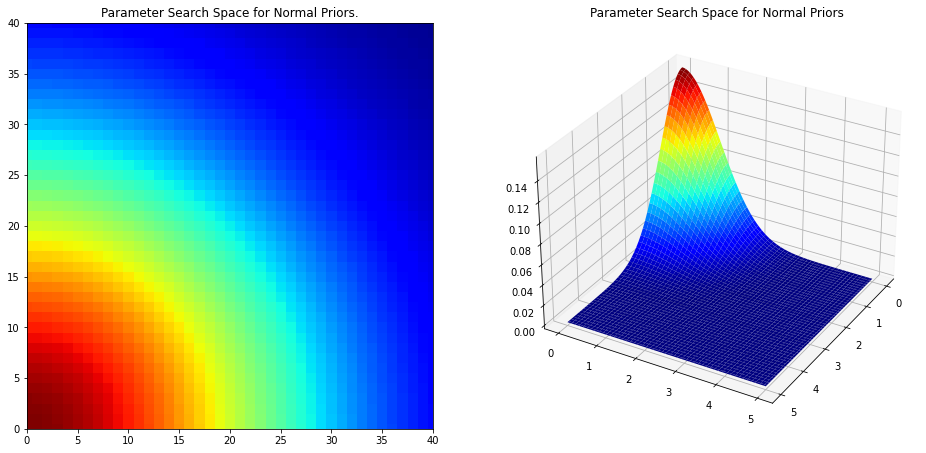

In [5]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(16, 8)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
norm_x = stats.norm.pdf(x, loc=0, scale=1)
norm_y = stats.norm.pdf(y, loc=0, scale=1)
M = np.dot(norm_x[:, None], norm_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet)

plt.xlim(0, 40)
plt.ylim(0, 40)
plt.title("Parameter Search Space for Normal Priors.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet)
ax.view_init(azim=390)
plt.title("Parameter Search Space for Normal Priors");

The expected value of a normal distribution is the mean.$$ E[ X | \mu, \tau] = \mu$$

The variance of a normal distribution is equal to:

$$ Var[ X | \mu, \tau) = \frac{1}{\tau}$$
Again, we have no assumptions about the value for either $\mu$ or $\tau$ in the prior distributions for $\alpha$ and $\beta$. When we initialize the model, we can use $\mu = 0$ and a relatively large variance such as $\tau = 0.05$. Markov Chain Monte Carlo will samples values of $\mu$ and $\tau$ that try to maximize the likelihood of $\alpha$ and $\beta$ under the data.

### Markov Chain Monte Carlo

Markov Chain Monte Carlo will sample both $\beta$ and $\alpha$ from two normal distributions to find the parameters. Each iteration (state), an estimate for both $\beta$ and $\alpha$ are drawn from the prior. If the parameters increase the probabilty of the data, the state is accepted, but if the parameters are not in agreement with the data, the state is rejected. Monte Carlo refers to the sampling part of the algorithm. Markov Chain means that the next state is only dependent on the current state in a first order process (second order depends on the current and 1 previous step, third order on the current and 2 previous steps and so on). MCMC will return every sample of the parameters for the number of specified steps. This is known as the model trace. To find the most likely parameters, we can take the average of the samples in the trace. MCMC does not given an exact answer, but rather tries to find the maximum likelihood states under the data.

When modeling with MCMC up to 50% of the initial steps, referred to as the burn-in part of the trace, are discarded because the algorithm returns more likely parameters as the number of samples increases. The initial samples are less likely than the latter samples on average. There are a number of methods to test for convergence of MCMC, including visually inspecting the trace, and calculating the auto-correlation of the trace (a lower auto-correlation is an indicator of convergence). We will look at the trace in this example, but will not take rigorous steps to address convergence. There are also a number of methods to choose a smart starting value for the Markov Chain such as Maximum A Posterior estimation. Choosing an intelligent initial value can speed up convergence.

### Posterior Probability of Sleep given Time

We have all the pieces for the poesterior probabilty and can now put them together. The logistic function describes the transition from awake to asleep, but we do not konw the parameters $\beta$ and $\alpha$. The aim is to find the parameters of the logistic function which maximize the likelihood of the observed data. The parameters are assumed to come from a normal distribution defined by a mean, $\mu$ and a variance, $\tau$. The MCMC algorithm will sample values of $\mu$ and $\tau$ for both $\alpha$ and $\beta$ to try and maximize the parameters of the logistic function given the data.

The data is connected to the parameters through a Bernoulli Variable.

### Bernoulli Variable

A bernoulli variable is a discrete random variable that is either 0 or 1. In our example, we can model asleep or awake as a Bernoulli variable where awake is 0 and asleep is 1. The Bernoulli variable for sleep depends on the time, in a manner defined by the logistic function.

$$ \text{Sleep Probability, $S_i$} \sim \text{Ber}( \;p(t_i)\; ), \;\; i=1..N$$
$p(t_i)$ is the logistic function with the independent variable time, so this becomes:

$$ P(\text{sleep} | t_i) = \text{Ber}(\frac{1}{1 + e^{(\beta t_i + \alpha)}})$$
The goal of MCMC is to find the $\alpha$ and $\beta$ parameters using the data and assuming normal priors.

### Pyro Model:


In [6]:
# Sort the values by time offset
sleep_data.sort_values('time_offset', inplace=True)

# Time is the time offset
time = np.array(sleep_data.loc[:, 'time_offset'])

# Observations are the indicator
sleep_obs = np.array(sleep_data.loc[:, 'indicator'])

In [16]:
import torch
import pyro
import torch.distributions as dist

import time as tm
# Import our libraries
import pyro.distributions as pyrodist
import pyro.contrib.autoguide as autoguide
from pyro.infer import MCMC, NUTS, HMC

N_SAMPLES = 5000
device = 'cuda'
# Define the process
def model(observations,time_my):
    alpha = pyro.sample("alpha", pyrodist.Normal(0.0, 1.0))
    beta = pyro.sample("beta", pyrodist.Normal(0.0, 1.0))
    p = pyro.deterministic('p', 1. / (1. + torch.exp(beta * time_my + alpha)))
    mydist  = pyrodist.Bernoulli(p)

    with pyro.plate("data", len(observations)):
        pyro.sample("obs", mydist, obs=observations)



sl_obs = torch.from_numpy(sleep_obs).to(device).float()
time_t = torch.from_numpy(time).to(device).float()
#hmc_kernel = HMC(model, step_size=0.0855, num_steps=4)
#mcmc = MCMC(hmc_kernel, num_samples=500, warmup_steps=100)

nuts_kernel = NUTS(model, step_size=0.15)
mcmc = MCMC(nuts_kernel, num_samples=5000, warmup_steps=100)

mcmc.run(sl_obs, time_t)

sleep_trace  = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}


# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

for site, values in summary(sleep_trace).items():
    print("Site: {}".format(site))
    print(values, "\n")



Sample: 100%|██████████| 5100/5100 [03:38, 23.33it/s, step size=1.68e-02, acc. prob=0.923]


Site: alpha
       mean       std        5%       25%       50%       75%       95%
0  0.972259  0.037723  0.910155  0.946357  0.971893  0.997248  1.033984 

Site: beta
       mean       std        5%       25%       50%       75%       95%
0 -0.067126  0.001269 -0.069259 -0.067942 -0.067105 -0.066264 -0.065085 



The trace variable contains all of the samples drawn from the posterior for $\beta$ and $\alpha$. We can graph these samples to explore how they change over the course of sampling. The idea of MCMC is that the samples get more likely given the data as the algorithm continues. In other words, the MCMC algorithm converges on the most likely values as the samples increase. We expect the latter values drawn from the posterior to be more accurate than the earlier values. In Markov Chain Monte Carlo, it is common practice to discard a portion of the samples, usually about 50%, which are known as the burn-in samples. For this report I am not discarding any samples, but in a real application, we would run the model for many more steps and discard the initial samples.

### Visualize Posteriors for $\beta$ and $\alpha$

The values returned in the trace are all the samples drawn for the parameters. We can visually inspect these values in histograms.

In [25]:
# Extract the alpha and beta samples
alpha_samples = sleep_trace["alpha"]
beta_samples = sleep_trace["beta"]

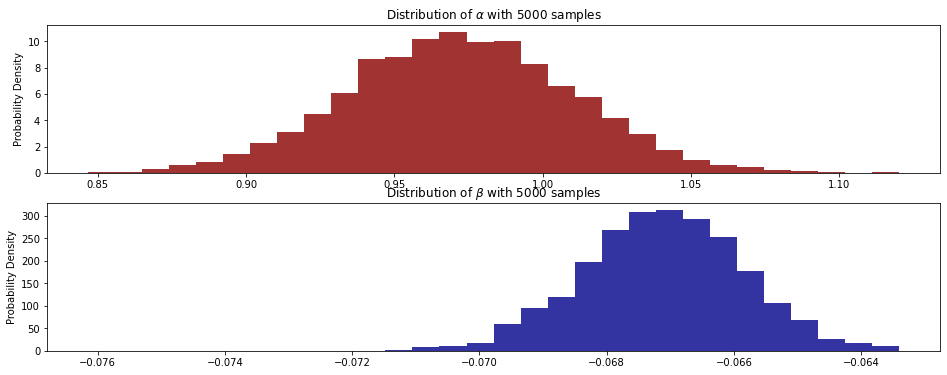

In [26]:
plt.figure(figsize=(16, 6))

plt.subplot(211)
plt.title(r"""Distribution of $\alpha$ with %d samples""" % N_SAMPLES)

plt.hist(alpha_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')


plt.subplot(212)
plt.title(r"""Distribution of $\beta$ with %d samples""" % N_SAMPLES)
plt.hist(beta_samples, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True)
plt.ylabel('Probability Density');

If the $\beta$ values were centered around 0 that would indicate time has no effect on the probability of being asleep. The $\alpha$ values also are not at 0, indicating that there is an offset from 10:00 pm in terms of being asleep. I choose to represent the times as an offset from 10:00 PM to avoid dealing with data times as much as possible.

The spread of the data gives us a measure of uncertainty about the data. A larger spread indicates more uncertainty. As there is considerable overlap in the observations for awake and asleep, the uncertainty is expected to be large. To find the most likely posterior distribution for sleep given the time, we take the average of the $\alpha$ and $\beta$ samples.

### Posterior for Sleep Visualization


In [63]:
# Time values for probability prediction
time_est = np.linspace(time.min()- 15, time.max() + 15, 5000)[:, None]

# Take most likely parameters to be mean values
alpha_est = alpha_samples.mean()
beta_est = beta_samples.mean()

# Probability at each time using mean values of alpha and beta
sleep_est = logistic(time_est, beta=beta_est, alpha=alpha_est)

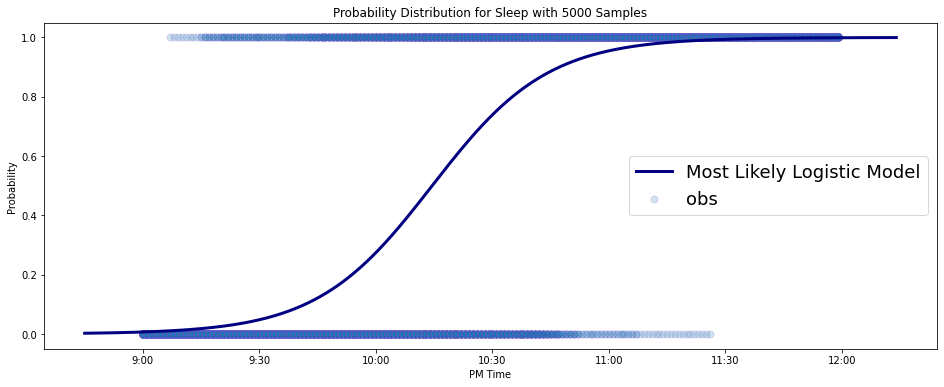

In [115]:
plt.figure(figsize=(16, 6))

plt.plot(time_est, sleep_est, color = 'navy', 
         lw=3, label="Most Likely Logistic Model")
plt.scatter(time, sleep_obs, edgecolor = 'slateblue',
            s=50, alpha=0.2, label='obs')
plt.title('Probability Distribution for Sleep with %d Samples' % N_SAMPLES);
plt.legend(prop={'size':18})
plt.ylabel('Probability')
plt.xlabel('PM Time');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

The posterior probability increases from 0 to 1 as the time gets later. The model is not perfect because of the noise in the data, but it is an adequate approximation based on the observations and can provide useful estimates.

In [65]:
print('The probability of sleep increases to above 50% at 10:{} PM.'.format(int(time_est[np.where(sleep_est > 0.5)[0][0]][0])))

The probability of sleep increases to above 50% at 10:14 PM.


In [66]:
st_b = torch.from_numpy(sleep_trace['beta'])
st_a = torch.from_numpy(sleep_trace['alpha'])
time_est_t = torch.from_numpy(time_est)
pp = pyro.deterministic('p', 1. / (1. + torch.exp(st_b * time_est_t + st_a)))
mydistp  = pyrodist.Bernoulli(pp)

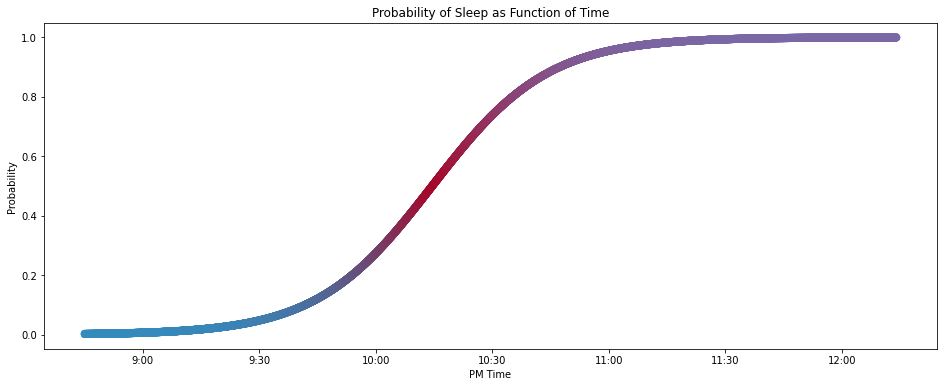

In [112]:
colors = ["#348ABD", "#A60628", "#7A68A6"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("BMH", colors)
plt.figure(figsize=(16, 6))
probs = pp.numpy()

plt.scatter(time_est_t, probs.mean(axis=1), cmap = cmap, 
            c = probs.mean(axis=1), s = 50);
plt.title('Probability of Sleep as Function of Time')
plt.xlabel('PM Time');
plt.ylabel('Probability');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

The posterior can be queried at any time (as an offset from 10:00 PM) to find the probability I am asleep.

In [69]:
print('10:00 PM probability of being asleep: {:.2f}%.'.
      format(100 * logistic(0, beta_est, alpha_est)))
print('9:30  PM probability of being asleep: {:.2f}%.'.
      format(100 * logistic(-30, beta_est, alpha_est)))
print('10:30 PM probability of being asleep: {:.2f}%.'.
      format(100 * logistic(30, beta_est, alpha_est)))

10:00 PM probability of being asleep: 27.44%.
9:30  PM probability of being asleep: 4.81%.
10:30 PM probability of being asleep: 73.91%.


### Posterior Probability Distribution for Specific Time

We can also plot the posterior distribution of sleep at a time as a histogram based on all of the samples for the paramters. This gives us another look at the uncertainty in the model.

In [116]:
def sleep_posterior(time_offset, time):
    plt.figure(figsize=(16, 6))
    prob = logistic(time_offset, beta_samples, alpha_samples)
    plt.hist(prob, bins=100, histtype='step', lw=4)
    plt.title('Probability Distribution for Sleep at %s PM' % time)
    plt.xlabel('Probability of Sleep'); plt.ylabel('Samples')
    plt.show();

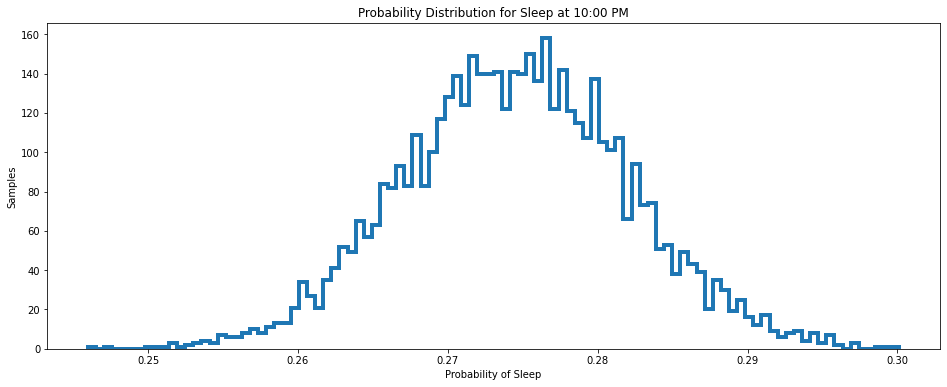

In [117]:
sleep_posterior(0, '10:00')

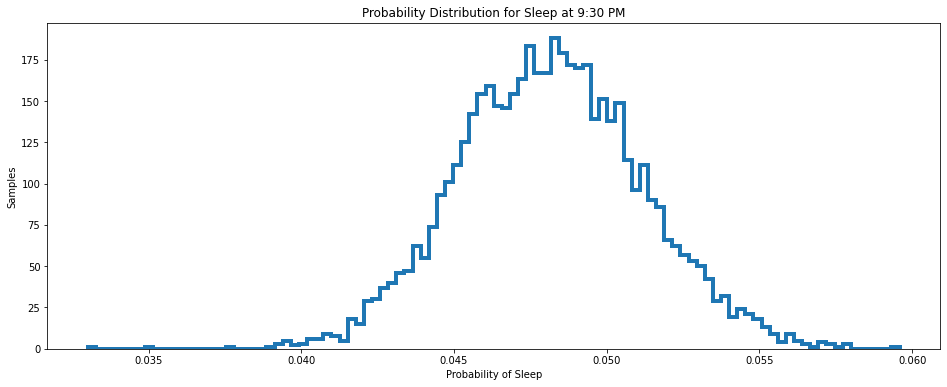

In [118]:
sleep_posterior(-30, '9:30')

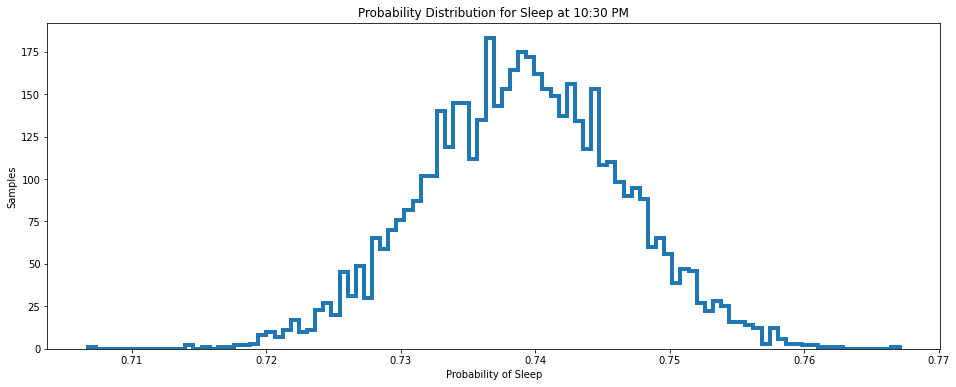

In [119]:
sleep_posterior(30, '10:30')

In [120]:
print('Most likely alpha parameter: {:.6f}.'.format(alpha_est))
print('Most likely beta  parameter: {:.6f}.'.format(beta_est))

Most likely alpha parameter: 0.972259.
Most likely beta  parameter: -0.067126.


### Convergence in Markov Chain Monte Carlo

How can we know if the model converged? We can look at the trace, or the path of the values over sampling. Another option is to look at the auto-correlation of the samples. In Markov Chain modeling, the samples are correlated with themselves because the next value depends on the current state (or the current state and past states based on the order). Initially, the algorithm tends to wander about the search space and will have a high auto-correlation. As the algorithm converges, the samples will settle down around a value and one measure of convergence is a low auto-correlation. We will not do a rigorous study of convergence in this report, but we can plot the traces of all the samples.

Trace Plots
The plots below show all the samples of $\alpha$ and $\beta$ from the algorithm.

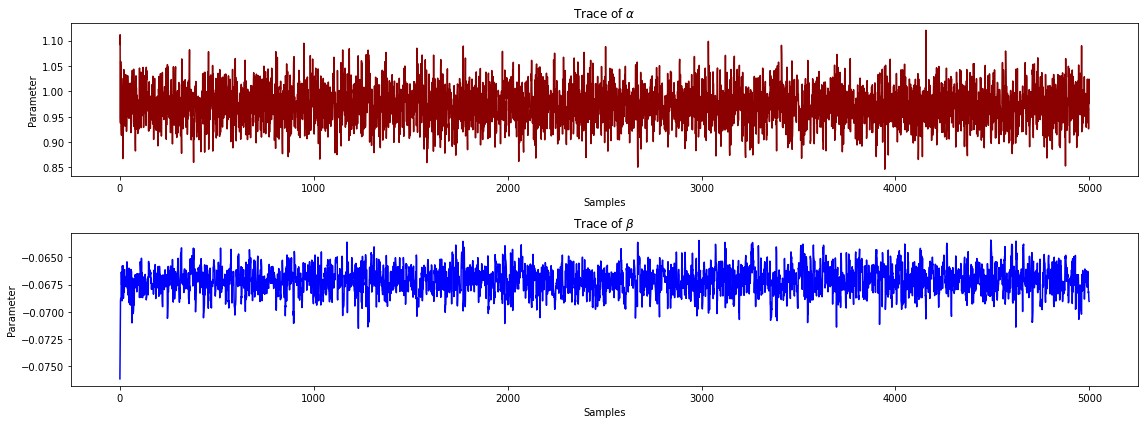

In [123]:
plt.figure(figsize=(16, 6))

# Plot alpha trace
plt.subplot(211)
plt.title(r'Trace of $\alpha$')
plt.plot(alpha_samples, color = 'darkred')
plt.xlabel('Samples'); plt.ylabel('Parameter');

# Plot beta trace
plt.subplot(212)
plt.title(r'Trace of $\beta$')
plt.plot(beta_samples, color='b')
plt.xlabel('Samples'); plt.ylabel('Parameter');
plt.tight_layout(h_pad=0.8)

### Model for Sleep Duration

We can also form a model to estimate the most likely length of time I am asleep. We can first look at the data and then determine which function fits the probability distribution.

In [125]:
raw_data = pd.read_csv('sleep_wake.csv')
raw_data['length'] = 8 - (raw_data['Sleep'] / 60) + (raw_data['Wake'] / 60)
duration = raw_data['length']

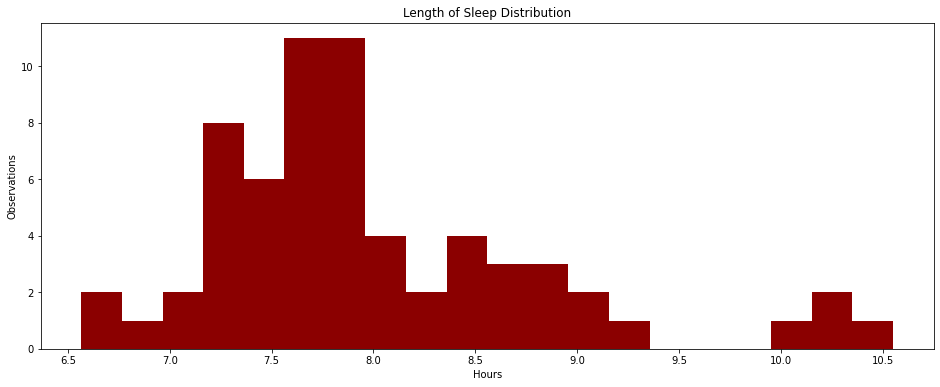

In [126]:
plt.figure(figsize=(16, 6))
plt.hist(duration, bins = 20, color = 'darkred')
plt.xlabel('Hours'); plt.title('Length of Sleep Distribution'); 
plt.ylabel('Observations');

The distribution is skewed to the right. Therefore, we can used a skewed distribution to model the length of sleep. We might also want to use a bi-modal distribution because there appear to be two modes. For now, I will stick to representing the length of sleep distribution as a skewed normal. A skewed normal distribution is shown below.

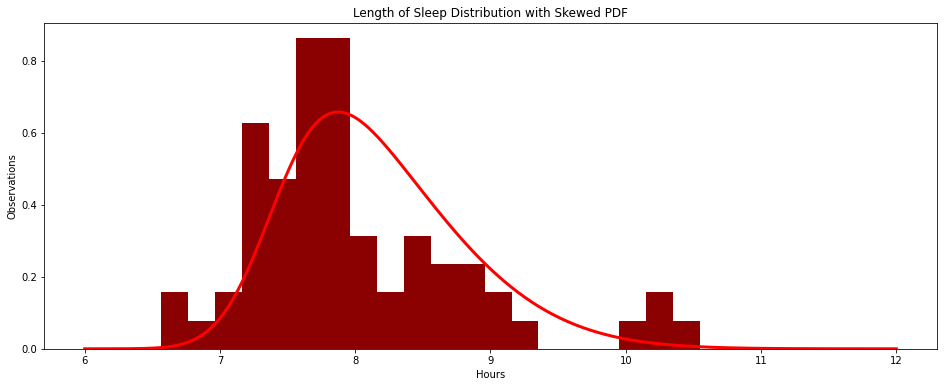

In [131]:
a = 3
x = np.linspace(6, 12, 1000)


plt.figure(figsize=(16, 6))
plt.hist(duration, bins = 20, color = 'darkred', density= True)
plt.xlabel('Hours'); plt.title('Length of Sleep Distribution with Skewed PDF'); 
plt.ylabel('Observations');
plt.plot(x, stats.skewnorm.pdf(x, a, loc = 7.4, scale=1), 'r-', 
         lw=3, label='skewnorm pdf');